# Show classic screening curve analysis for generation investment

Compute the long-term equilibrium power plant investment for a given load duration curve (1000-1000z for z \in [0,1]) and a given set of generator investment options.

Available as a Jupyter notebook at http://www.pypsa.org/examples/generation-investment-screening-curve.ipynb.


In [24]:
import pypsa
import numpy as np
import pandas as pd
%matplotlib inline

In [25]:
#Generator marginal (m) and capital (c) costs in EUR/MWh - numbers chosen for simple answer
generators = {"coal" : {"m" : 2, "c" : 15},
              "gas" : {"m" : 12, "c": 10},
              "load-shedding" : {"m" : 1012, "c" : 0}}

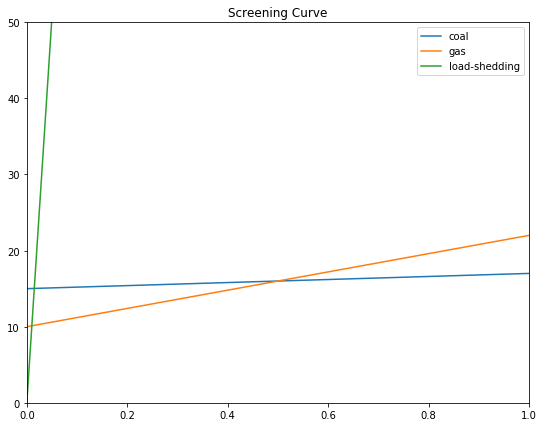

In [45]:
#Screening curve intersections at 0.01 and 0.5
x = np.linspace(0,1,101)
df = pd.DataFrame({key : pd.Series(item["c"] + x*item["m"],x) for key,item in generators.items()})
df.plot(ylim=[0,50],title="Screening Curve", figsize = (9,7))

In [28]:
n = pypsa.Network()

num_snapshots = 1001

snapshots = np.linspace(0,1,num_snapshots)

n.set_snapshots(snapshots)

n.snapshot_weightings = n.snapshot_weightings/num_snapshots

n.add("Bus",name="bus")

n.add("Load",name="load",bus="bus",
      p_set=1000-1000*snapshots)

for gen in generators:
    n.add("Generator",name=gen,bus="bus",
          p_nom_extendable=True,
          marginal_cost=float(generators[gen]["m"]),
          capital_cost=float(generators[gen]["c"]))

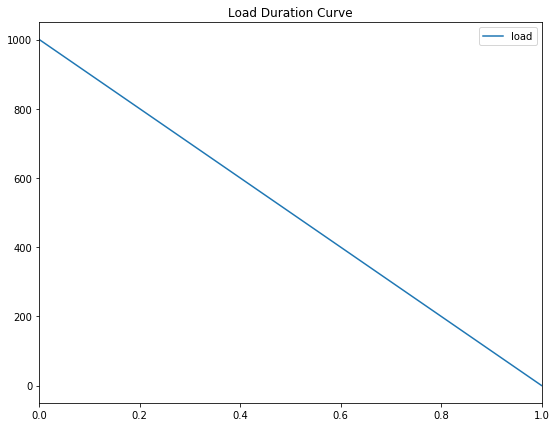

In [29]:
n.loads_t.p_set.plot(title="Load Duration Curve", figsize = (9,7))

In [30]:
n.lopf(solver_name="cbc")

INFO:pypsa.opf:Performed preliminary steps
INFO:pypsa.opf:Building pyomo model using `kirchhoff` formulation
INFO:pypsa.opf:Solving model using cbc
INFO:pypsa.opf:Optimization successful


# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Name: unknown
  Lower bound: 14706.19381
  Upper bound: 14706.19381
  Number of objectives: 1
  Number of constraints: 7008
  Number of variables: 3007
  Number of nonzeros: 3002
  Sense: minimize
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Status: ok
  User time: -1.0
  System time: 0.06
  Wallclock time: 0.08
  Termination condition: optimal
  Termination message: Model was solved to optimality (subject to tolerances), and an optimal solution is available.
  Statistics: 
    Branch and bound: 
      Number of bounded subproblems: None
    

('ok', 'optimal')

In [31]:
print(n.objective)

14706.19381


In [32]:
#capacity set by total electricity required
#NB: no load shedding since all prices < 1e4
n.generators.p_nom_opt.round(2)

coal             500.0
gas              490.0
load-shedding     10.0
Name: p_nom_opt, dtype: float64

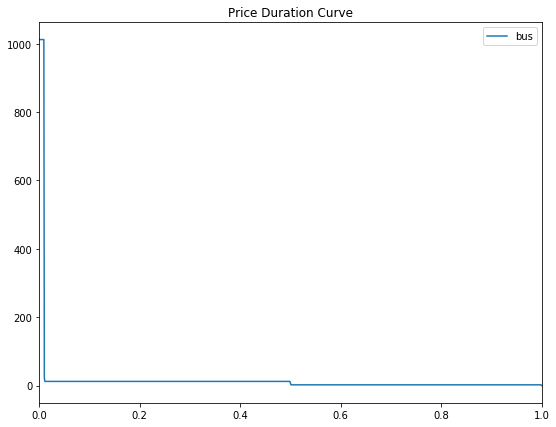

In [35]:
n.buses_t.marginal_price.plot(title="Price Duration Curve", figsize = (9,7))

In [36]:
#The prices correspond either to VOLL (1012) for first 0.01 or the marginal costs (12 for 0.49 and 2 for 0.5)

#EXCEPT for (infinitesimally small) points at the screening curve intersections, which
#correspond to changing the load duration near the intersection, so that capacity changes
#This explains 7 = (12+10 - 15) (replacing coal with gas) and 22 = (12+10) (replacing load-shedding with gas)

#I have no idea what is causing \l = 0; it should be 2.

n.buses_t.marginal_price.round(2).sum(axis=1).value_counts()

2.0       499
12.0      489
1012.0     10
0.0         1
7.0         1
22.0        1
dtype: int64

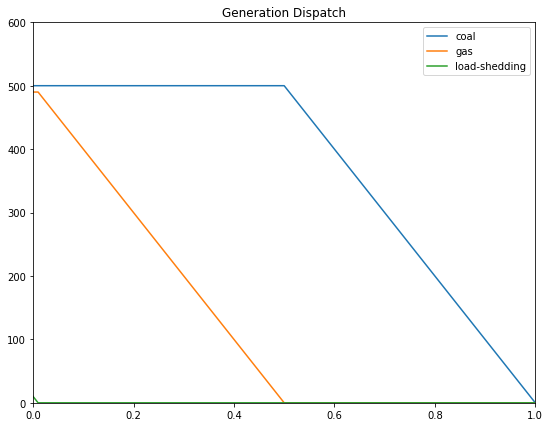

In [37]:
n.generators_t.p.plot(ylim=[0,600],title="Generation Dispatch", figsize = (9,7))

In [38]:
#Demonstrate zero-profit condition
print("Total costs:")
print(n.generators.p_nom_opt*n.generators.capital_cost + n.generators_t.p.multiply(n.snapshot_weightings,axis=0).sum()*n.generators.marginal_cost)



print("\nTotal revenue:")
print(n.generators_t.p.multiply(n.snapshot_weightings,axis=0).multiply(n.buses_t.marginal_price["bus"],axis=0).sum())

Total costs:
coal             8249.750250
gas              6400.839161
load-shedding      55.604396
dtype: float64

Total revenue:
coal             8249.750198
gas              6400.839108
load-shedding      55.604395
dtype: float64


# Without expansion optimisation

Take the capacities from the above long-term equilibrium, then disallow expansion.

Show that the resulting market prices are identical.

This holds in this example, but does NOT necessarily hold and breaks down in some circumstances (for example, when there is a lot of storage and inter-temporal shifting).

In [39]:
n.generators.p_nom_extendable = False
n.generators.p_nom = n.generators.p_nom_opt

In [40]:
n.lopf(solver_name='glpk')

INFO:pypsa.opf:Performed preliminary steps
INFO:pypsa.opf:Building pyomo model using `kirchhoff` formulation
INFO:pypsa.opf:Solving model using glpk
INFO:pypsa.opf:Optimization successful


# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Name: unknown
  Lower bound: 2306.19380619383
  Upper bound: 2306.19380619383
  Number of objectives: 1
  Number of constraints: 1002
  Number of variables: 3004
  Number of nonzeros: 3004
  Sense: minimize
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Status: ok
  Termination condition: optimal
  Statistics: 
    Branch and bound: 
      Number of bounded subproblems: 0
      Number of created subproblems: 0
  Error rc: 0
  Time: 0.12139701843261719
# ----------------------------------------------------------
#   Solution Information
# ------

('ok', 'optimal')

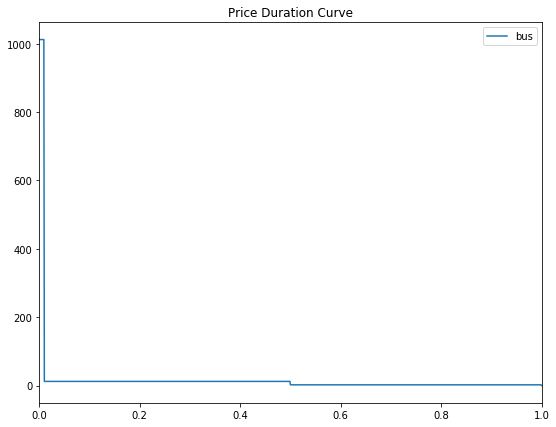

In [42]:
n.buses_t.marginal_price.plot(title="Price Duration Curve", figsize = (9,7))

In [43]:
n.buses_t.marginal_price.sum(axis=1).value_counts()

2.0       500
12.0      490
1012.0     10
0.0         1
dtype: int64

In [44]:
#Demonstrate zero-profit condition

#Differences are due to singular times, see above, not a problem

print("Total costs:")
print(n.generators.p_nom*n.generators.capital_cost + n.generators_t.p.multiply(n.snapshot_weightings,axis=0).sum()*n.generators.marginal_cost)



print("Total revenue:")
print(n.generators_t.p.multiply(n.snapshot_weightings,axis=0).multiply(n.buses_t.marginal_price["bus"],axis=0).sum())

Total costs:
coal             8249.750250
gas              6400.839161
load-shedding      55.604396
dtype: float64
Total revenue:
coal             8242.257742
gas              6395.944056
load-shedding      55.604396
dtype: float64
